In [1]:
from typing import List
import pathlib as pl
import json
import os
from datetime import datetime

import openai

from sklearn import metrics as skm

with open('/Users/azadoks/.zshrc.d/10_openai_bot.sh', 'r') as f:
    api_key = f.read().split('=')[1].strip()

client = openai.OpenAI(api_key=api_key)

In [2]:
def load_jsonl(filename: os.PathLike) -> List[dict]:
    data = []
    with open(filename, 'r') as f:
        for line in f.readlines():
            data.append(json.loads(line.strip()))
    return data

def predict(job_id: str, prompts) -> List:
    response = client.fine_tuning.jobs.retrieve(job_id)
    fine_tuned_model_id = response.fine_tuned_model

    responses = []
    for prompt in prompts:
        if isinstance(prompt, dict):
            prompt = prompt['prompt']
        response = client.completions.create(
            model=fine_tuned_model_id,
            prompt=prompt,
            stop='nm',
            temperature=0
        )
        responses.append(response.to_dict())

    return responses

def generate(job_id: str, prompts, temperature: float=0.5, max_tokens: int=256) -> List:
    response = client.fine_tuning.jobs.retrieve(job_id)
    fine_tuned_model_id = response.fine_tuned_model

    responses = []
    for prompt in prompts:
        if isinstance(prompt, dict):
            prompt = prompt['prompt']
        response = client.completions.create(
            model=fine_tuned_model_id,
            prompt=prompt,
            stop='###',
            temperature=temperature,
            max_tokens=max_tokens
        )
        responses.append(response.to_dict())

    return responses

In [3]:
experiment_name = 'smi-emi-ib271014'
experiment_dir = pl.Path(f'../data/{experiment_name}/')
with open(experiment_dir / 'job_id.txt', 'r') as f:
    job_id = f.read().strip()
train_data = load_jsonl(experiment_dir / 'train.jsonl')
validate_data = load_jsonl(experiment_dir / 'validate.jsonl')
test_data = load_jsonl(experiment_dir / 'test.jsonl')

In [6]:
generate(job_id, prompts=['What is a molecule and solvent pair with an emission maximum wavelength of 200 nm?'])

[{'id': 'cmpl-9TaENOHIgJEP3D9EDXD6lXTL5PBkl',
  'choices': [{'finish_reason': 'length',
    'index': 0,
    'logprobs': None,
    'text': 'Molecule SMILES: CCn1c2ccccc2c2cc(C3=[O+][B-](F)(F)OC(c4ccc(OC)cc4)=C3c3ccccc3)ccc21\nSolvent SMILES: CCOC(C)=OCCO(C)OC(C)C\nCavity SMILES: CC#N=C(C(=O)OCCO(C)C)C#N\nC1(C)C(=O)O\nC(=O)O\nC=O\nC3=O\nC(=O)O\nC=O\nC1(C)C(=O)O\nC(=O)O\nC=O\nC=O\nC2=O\nC(=O)O\nC(=O)O\nC=O\nC=O\nC=O\nC2=O\nC(=O)O\nC(=O)O\nC=O\nC=O\nC=O\nC=O\nC=O\nC=O\nC=O\nC=O\nC=O\nC=O\nC=O\nC=O\n'}],
  'created': 1716837811,
  'model': 'ft:babbage-002:austin:smi-emi-ib271014:9TQ6Z3oU',
  'object': 'text_completion',
  'usage': {'completion_tokens': 256,
   'prompt_tokens': 17,
   'total_tokens': 273}}]

In [3]:
experiment_names = ['sel-abs-b231212', 'sel-emi-b231204', 'smi-abs-b231214', 'smi-emi-b231214']

experiment_data = {}
for experiment_name in experiment_names:
    experiment_dir = pl.Path(f'../data/{experiment_name}/')
    with open(experiment_dir / 'job_id.txt', 'r') as f:
        job_id = f.read().strip()
    train_data = load_jsonl(experiment_dir / 'train.jsonl')
    validate_data = load_jsonl(experiment_dir / 'validate.jsonl')
    test_data = load_jsonl(experiment_dir / 'test.jsonl')
    experiment_data[experiment_name] = {
        'job_id': job_id,
        'train_data': train_data,
        'validate_data': validate_data,
        'test_data': test_data
    }

In [60]:
def get_molecule(prompt: str) -> str:
    predicate = prompt.split('molecule')[1]
    molecule = predicate.split()[0]
    return molecule

def get_solvent(prompt: str) -> str:
    predicate = prompt.split('dissolved in')[1]
    solvent = predicate.split()[0]
    return solvent

In [66]:
N = 1
results = {}
for experiment_name, experiment in experiment_data.items():
    print(experiment_name)
    results[experiment_name] = {}
    data = experiment['test_data'][500:500+N]
    prompts = [d['prompt'] for d in data]
    completions = predict(experiment['job_id'], prompts)

    results[experiment_name]['y'] = [int(d['completion'].strip().split()[0]) for d in data]
    results[experiment_name]['completions'] = completions
    results[experiment_name]['yhat'] = [int(c['choices'][0]['text'].strip()) for c in completions]
    results[experiment_name]['molecules'] = [get_molecule(d['prompt']) for d in data]
    results[experiment_name]['solvents'] = [get_solvent(d['prompt']) for d in data]

    results_filename = pl.Path(f'../data/{experiment_name}/results.json')
    if results_filename.exists():
        old_results = json.load(open(results_filename, 'r'))
        for key in results[experiment_name].keys():
            results[experiment_name][key] = old_results[key] + results[experiment_name][key]

    results_filename.rename(results_filename.with_suffix(f'.{datetime.now().isoformat()}.json'))
    # print(results_filename.with_suffix(f'.{datetime.now().isoformat()}.json'))

    with open(f'../data/{experiment_name}/results.json', 'w') as f:
        json.dump(results[experiment_name], f)

sel-abs-b231212
sel-emi-b231204
smi-abs-b231214
smi-emi-b231214


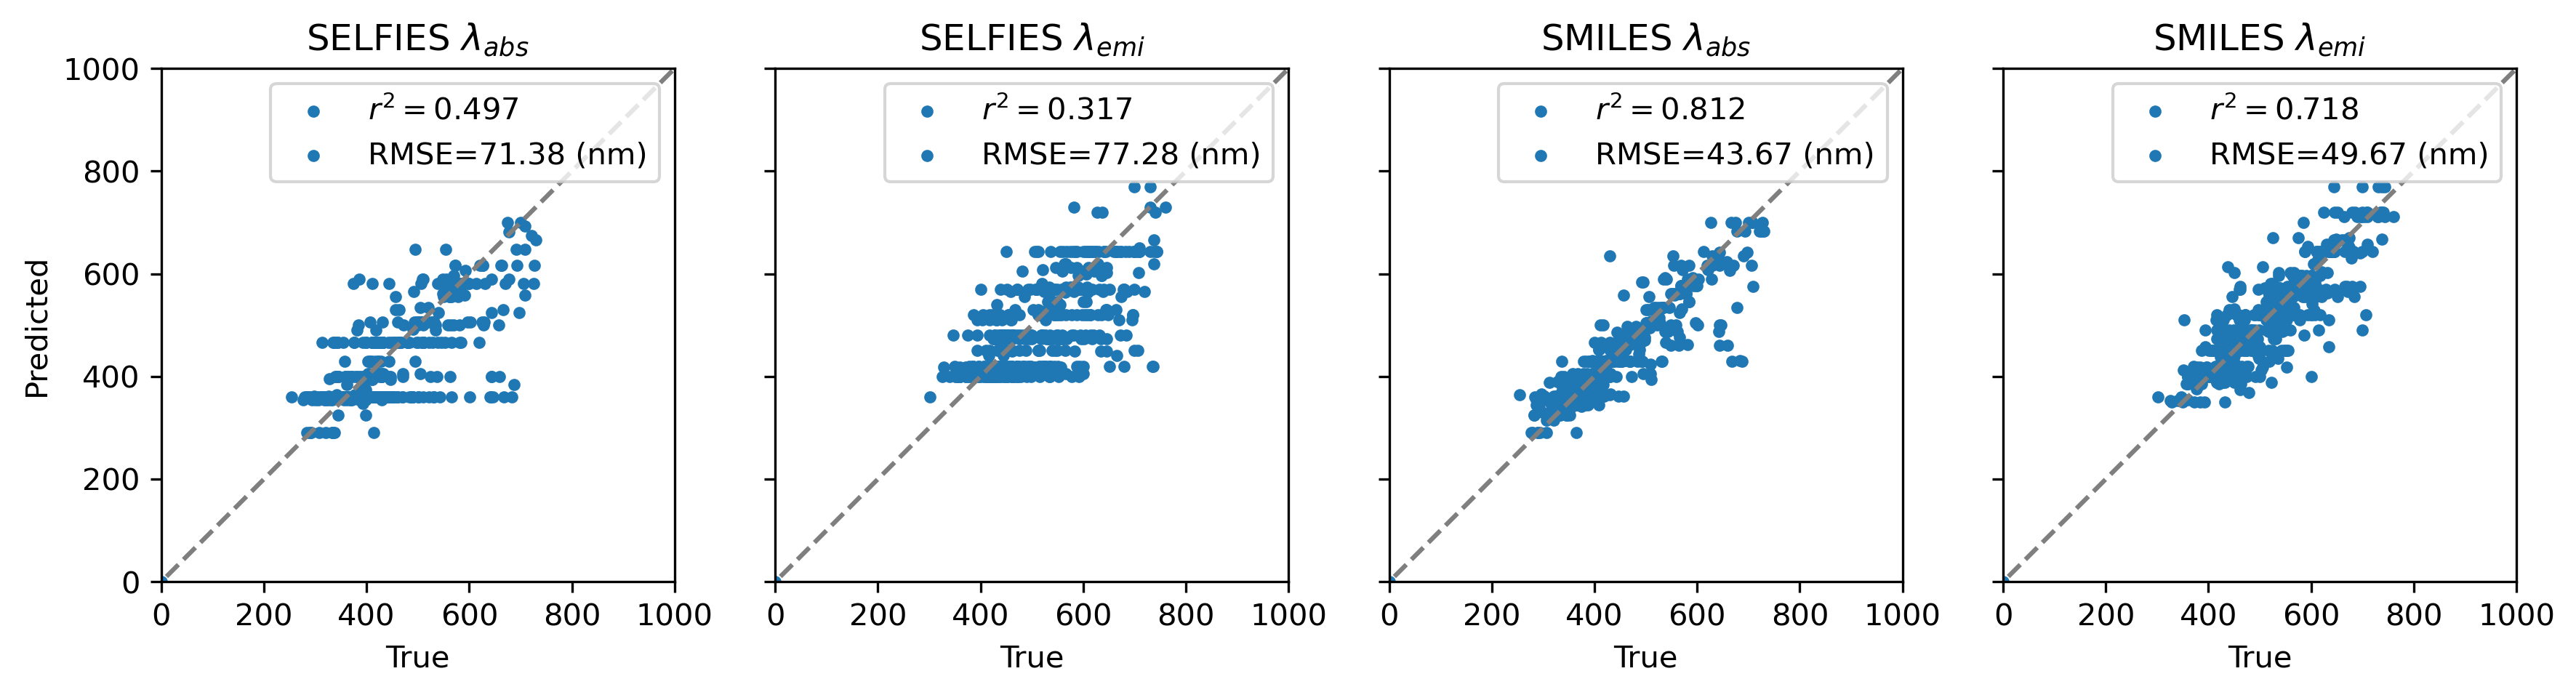

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12,3), dpi=300)
axes = axes.flatten()

results = {}
for experiment_name in experiment_names:
    with open(f'../data/{experiment_name}/results.json', 'r') as f:
        results[experiment_name] = json.load(f)

for (i, experiment_name) in enumerate(experiment_names):
    representation = {'sel': 'SELFIES', 'smi': 'SMILES'}[experiment_name.split('-')[0]]
    property_name = {'abs': 'absorption', 'emi': 'emission'}[experiment_name.split('-')[1]][:3]

    with open(f'../data/{experiment_name}/results.json', 'r') as f:
        experiment_results = json.load(f)

    r2 = skm.r2_score(experiment_results['y'], experiment_results['yhat'])
    rmse = skm.mean_squared_error(experiment_results['y'], experiment_results['yhat'], squared=False)

    axes[i].scatter(experiment_results['y'], experiment_results['yhat'], c='tab:blue', marker='.', label='$r^2=$' + f'{r2:.3f}')
    axes[i].scatter([0], [0], c='tab:blue', marker='.', label=f'RMSE={rmse:.2f} (nm)')
    axes[i].plot([-1000, 1000], [-1000, 1000], c='tab:gray', linestyle='--')
    axes[i].set_aspect('equal')
    axes[i].set_xlim(0, 1000)
    axes[i].set_ylim(0, 1000)
    if i == 0:
        axes[i].set_ylabel('Predicted')
    axes[i].set_xlabel('True')
    axes[i].set_title(f'{representation} ' + f'$\lambda_{{{property_name}}}$')
    axes[i].legend()

fig.tight_layout()

fig.savefig('../plots/babbage_results.png')
fig.savefig('../plots/babbage_results.pdf')

In [89]:
with open('/Users/azadoks/Source/ai_for_chemistry/data/smiles_emission_finetune_gpt-3.5-turbo/smi-emis-gpt-3.5-turbo-0125-5k.json', 'r') as f:
    gpt_results = json.load(f)

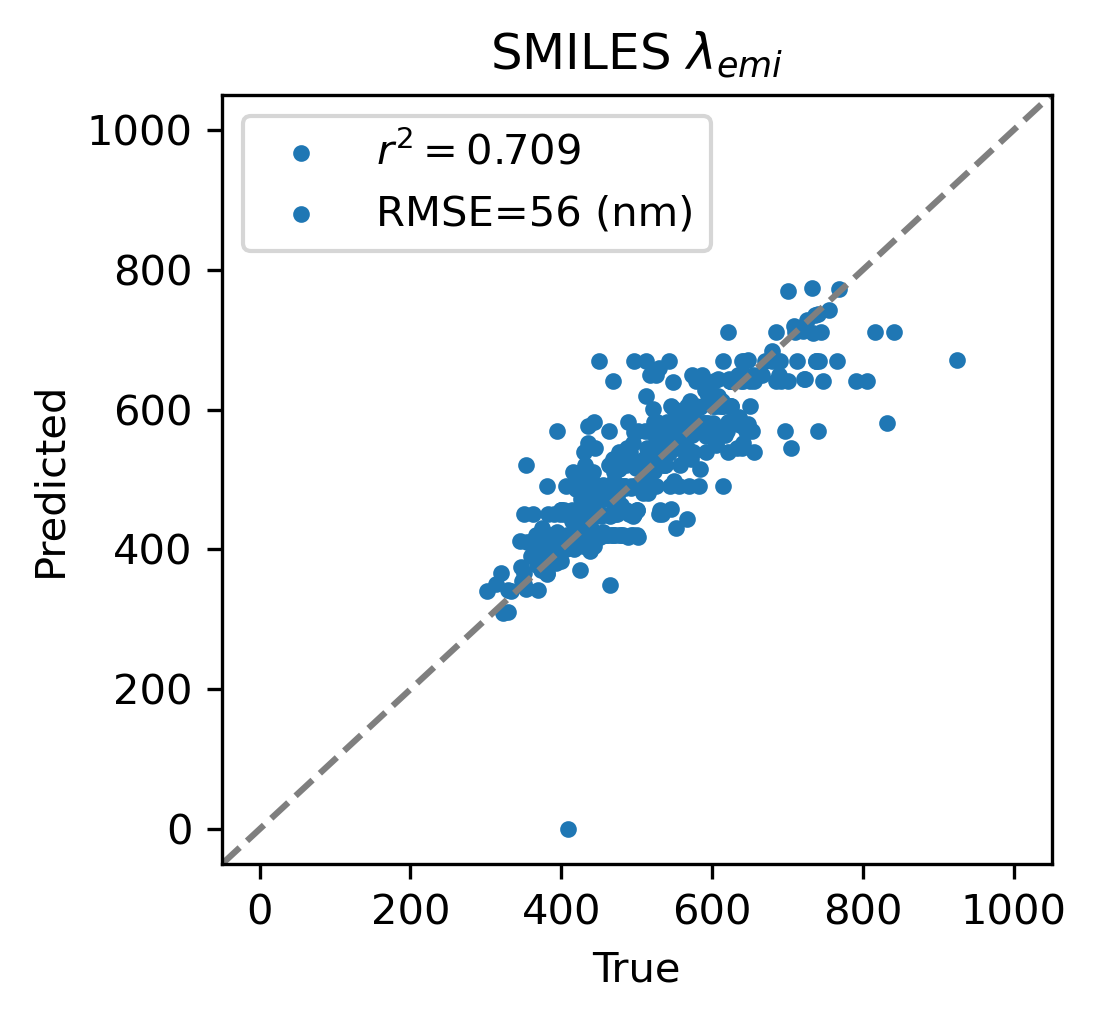

In [103]:
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(3.75,3.5), dpi=300)

r2 = skm.r2_score(gpt_results['y'], gpt_results['yhat'])
rmse = skm.mean_squared_error(gpt_results['y'], gpt_results['yhat'], squared=False)

ax.scatter(gpt_results['y'], gpt_results['yhat'], c='tab:blue', marker='.', label='$r^2=$' + f'{r2:.3f}')
ax.scatter([np.nan], [np.nan], c='tab:blue', marker='.', label=f'RMSE={rmse:.0f} (nm)')
ax.plot([-2000, 2000], [-2000, 2000], c='tab:gray', linestyle='--')

ax.set_xlabel('True')
ax.set_ylabel('Predicted')
ax.set_xlim(-50, 1050)
ax.set_ylim(-50, 1050)
ax.set_title('SMILES $\lambda_{emi}$')

ax.legend()

fig.tight_layout()
fig.savefig('../plots/smi-emis-gpt-3.5-turbo-0125-5k.png')